In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = !unrar x /content/drive/MyDrive/Tumor_Dataset.rar

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
# === Load Dataset ===
DATASET_PATH = '/content/Tumor_Dataset'
CLASS_NAMES = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']
IMG_SIZE = (256, 256)
images = []
labels = []

In [16]:
for label, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

In [17]:
# === Train-Test Split ===
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [18]:
# === Build U-Net Model ===
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    return x

def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = conv_block(p3, 256)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = conv_block(u1, 128)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = conv_block(u2, 64)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = conv_block(u3, 32)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c7)

    model = keras.Model(inputs, outputs)
    return model

In [19]:
# === Compile and Train Model ===
model = unet_model(input_shape=(256, 256, 3), num_classes=4)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Reshape y_train and y_val to have the same spatial dimensions as the model output
y_train_reshaped = y_train.reshape((-1, 1, 1, 1))  # Add spatial dimensions
y_train_reshaped = tf.tile(y_train_reshaped, [1, 256, 256, 1]) # Tile to match output size

y_val_reshaped = y_val.reshape((-1, 1, 1, 1))  # Add spatial dimensions
y_val_reshaped = tf.tile(y_val_reshaped, [1, 256, 256, 1])  # Tile to match output size

history = model.fit(X_train, y_train_reshaped, validation_data=(X_val, y_val_reshaped), epochs=50, batch_size=16)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 107s 515ms/step - accuracy: 0.2788 - loss: 1.3629 - val_accuracy: 0.3837 - val_loss: 1.3428
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 79s 277ms/step - accuracy: 0.3513 - loss: 1.3400 - val_accuracy: 0.3592 - val_loss: 1.2987
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.3702 - loss: 1.3068 - val_accuracy: 0.3741 - val_loss: 1.2663
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.3781 - loss: 1.2847 - val_accuracy: 0.4357 - val_loss: 1.2132
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 272ms/step - accuracy: 0.4063 - loss: 1.2388 - val_accuracy: 0.4330 - val_loss: 1.2173
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.4111 - loss: 1.2174 - val_accuracy: 0.4423 - val_loss: 1.1936
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.4413 - loss: 1.1836 - val_accuracy: 0.4393 - val_loss: 1.1628
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.4540 - loss: 

In [21]:
#=== Evaluate Model ===
# Reshape y_val to have the same spatial dimensions as the model output for evaluation
y_val_reshaped_eval = y_val.reshape((-1, 1, 1, 1))  # Add spatial dimensions
y_val_reshaped_eval = tf.tile(y_val_reshaped_eval, [1, 256, 256, 1])  # Tile to match output size

evaluation = model.evaluate(X_val, y_val_reshaped_eval)  # Use the reshaped y_val for evaluation
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 913ms/step - accuracy: 0.8174 - loss: 1.0076
Validation Loss: 1.1114981174468994
Validation Accuracy: 0.803698718547821


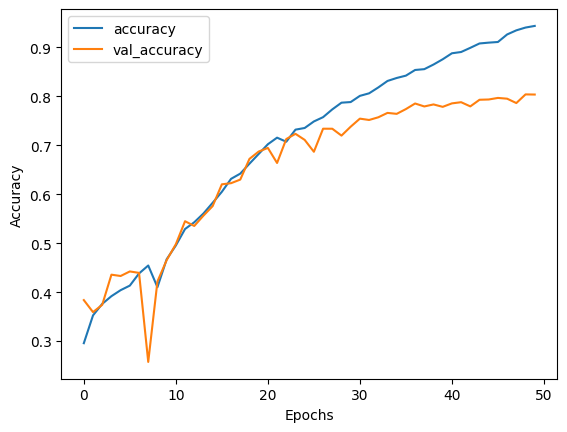

In [22]:
# === Plot Training History ===
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# === Load Dataset ===
DATASET_PATH = '/content/Tumor_Dataset'
CLASS_NAMES = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']
IMG_SIZE = (128, 128)
images = []
labels = []

for label, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

# === Train-Test Split ===
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# === Build U-Net Model ===
def conv_block(inputs, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu")(x)
    return x

def unet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = conv_block(p3, 256)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = conv_block(u1, 128)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = conv_block(u2, 64)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = conv_block(u3, 32)

    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(c7)

    model = keras.Model(inputs, outputs)
    return model

# === Compile and Train Model ===
model = unet_model(input_shape=(128, 128, 3), num_classes=4)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape y_train and y_val to have the same spatial dimensions as the model output
y_train_reshaped = y_train.reshape((-1, 1, 1, 1))  # Add spatial dimensions
y_train_reshaped = tf.tile(y_train_reshaped, [1, 128, 128, 1]) # Tile to match output size

y_val_reshaped = y_val.reshape((-1, 1, 1, 1))  # Add spatial dimensions
y_val_reshaped = tf.tile(y_val_reshaped, [1, 128, 128, 1])  # Tile to match output size

history = model.fit(X_train, y_train_reshaped, validation_data=(X_val, y_val_reshaped), epochs=50, batch_size=16)

# === Evaluate Model ===
y_val_reshaped_eval = y_val.reshape((-1, 1, 1, 1))
y_val_reshaped_eval = tf.tile(y_val_reshaped_eval, [1, 128, 128, 1])

evaluation = model.evaluate(X_val, y_val_reshaped_eval)
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')

# Save model
model.save('mri_tumor_segmentation_unet.h5')
print("Model training complete and saved as 'mri_tumor_segmentation_unet.h5'")


Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - accuracy: 0.3007 - loss: 1.3556 - val_accuracy: 0.3683 - val_loss: 1.3101
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.3457 - loss: 1.3243 - val_accuracy: 0.3878 - val_loss: 1.3067
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.3730 - loss: 1.3045 - val_accuracy: 0.4027 - val_loss: 1.2982
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.4262 - loss: 1.2200 - val_accuracy: 0.5119 - val_loss: 1.1303
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4677 - loss: 1.1499 - val_accuracy: 0.5263 - val_loss: 1.0737
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.4969 - loss: 1.0801 - val_accuracy: 0.5362 - val_loss: 1.0518
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5228 - loss: 1.0420 - val_accuracy: 0.5940 - val_loss: 0.9293
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5689 - loss: 0.9567 -

Validation Loss: 0.8825299143791199
Validation Accuracy: 0.8548485040664673
Model training complete and saved as 'mri_tumor_segmentation_unet.h5'


In [9]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [10]:
import numpy as np
print(np.__version__)

1.26.4


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# === Load Dataset ===
DATASET_PATH = '/content/Tumor_Dataset'
CLASS_NAMES = ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']
IMG_SIZE = (128, 128)
images = []
labels = []

# Load images and their corresponding labels
for label, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

# === Label Encoding ===
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# === Train-Test Split ===
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# === Build MobileNetV2 Model ===
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Build and Train the Classification Model ===
model = build_mobilenet_model(input_shape=(128, 128, 3), num_classes=len(CLASS_NAMES))

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

# === Evaluate Model ===
evaluation = model.evaluate(X_val, y_val)
print(f'Validation Loss: {evaluation[0]}')
print(f'Validation Accuracy: {evaluation[1]}')

# Save the classification model
model.save('tumor_classification_mobilenetv2.h5')
print("Classification model training complete and saved as 'tumor_classification_mobilenetv2.h5'")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 43s 260ms/step - accuracy: 0.7228 - loss: 0.7237 - val_accuracy: 0.8693 - val_loss: 0.3579
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.8893 - loss: 0.3161 - val_accuracy: 0.8868 - val_loss: 0.3183
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.9231 - loss: 0.2194 - val_accuracy: 0.9007 - val_loss: 0.2709
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.9451 - loss: 0.1667 - val_accuracy: 0.9077 - val_loss: 0.2534
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 41s 229ms/step - accuracy: 0.9666 - loss: 0.1139 - val_accuracy: 0.9111 - val_loss: 0.2506
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.9666 - loss: 0.0879 - val_accuracy: 0.9111 - val_loss: 0.2401
Epoch 7/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - accuracy: 0.9844 - loss: 0.0610 - val_accuracy: 0.9111 - val_loss: 0.2663
Epoch 8/20
144/144 ━━━━━━━━━━━━━━━

Validation Loss: 0.2621273994445801
Validation Accuracy: 0.9233449697494507
Classification model training complete and saved as 'tumor_classification_mobilenetv2.h5'
